In [1]:
import datetime
import heapq
import json
import multiprocessing as mp
import pathlib

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from config import DefaultDecoder, RSFHyperEncoder, RSFParams
from lifelines import CoxPHFitter, utils
from matplotlib import pyplot as plt
from metrics import plot_joint, predict_surv_exp_med, plot_coefficients
from preprocessing.pipeline import get_preprocessed_data
from preprocessing.pre_survival import prep_data_for_surv_analysis
from scipy.integrate import trapezoid
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, train_test_split
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw, cumulative_dynamic_auc
from sksurv.util import Surv
from statsmodels.duration.hazard_regression import PHReg, PHRegResults
from tqdm import tqdm

In [2]:
year = 2017
preprocessed_dir = pathlib.Path(f"../data/combined/year={year}")

try:
    df = pd.read_parquet(
        preprocessed_dir,
        )
    assert len(df) != 0
except AssertionError:
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')
    df.to_parquet(preprocessed_dir)
except FileNotFoundError:
    preprocessed_dir.mkdir()
    df = get_preprocessed_data(
        start_date=year,
        end_date=year+1,
        sectors=False,
        opened_created_add=['borough', 'precinct', 'complaint_type'],
    ).convert_dtypes(dtype_backend='pyarrow')

    df.to_parquet(preprocessed_dir)
except ValueError:
    boroughs = []
    for file_path in preprocessed_dir.glob('*'):

        if file_path.is_dir():
            try:
                boroughs.append(pd.read_parquet(file_path))
                # print(df)
            except Exception:
                print(file_path)

    df = pd.concat(boroughs)
df

,borough,precinct,complaint_type,created_H,closed_H,created_date,closed_date,agency,descriptor,status,...,precip_period_hrs,precip_accumulation_mm,direction_deg,speed_mps,dew_temperature_c,year,date_H,FELONY,MISDEMEANOR,VIOLATION
0,BRONX,40.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:47:15,2017-01-01 09:22:44,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,18,3
1,BRONX,43.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 14:00:00,2017-01-01 00:48:20,2017-01-01 14:12:14,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
2,BRONX,43.0,Drug Activity,2017-01-01 00:00:00,2017-01-01 06:00:00,2017-01-01 00:19:10,2017-01-01 06:07:03,NYPD,Use Indoor,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
3,BRONX,43.0,Noise - Residential,2017-01-01 00:00:00,2017-01-01 05:00:00,2017-01-01 00:47:44,2017-01-01 05:46:55,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,19,4
4,BRONX,44.0,Blocked Driveway,2017-01-01 00:00:00,2017-01-01 09:00:00,2017-01-01 00:26:29,2017-01-01 09:41:39,NYPD,No Access,Closed,...,<NA>,<NA>,200,7.7,-2.8,2017,2017-01-01 00:00:00,6,20,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489182,BROOKLYN,72.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:14:44,2018-12-31 23:31:57,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489183,MANHATTAN,19.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:39:13,2018-12-31 23:52:08,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489184,MANHATTAN,25.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:36:36,2018-12-31 23:51:07,NYPD,Loud Music/Party,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0
1489185,MANHATTAN,34.0,Noise - Residential,2018-12-31 23:00:00,2018-12-31 23:00:00,2018-12-31 23:11:23,2018-12-31 23:15:41,NYPD,Banging/Pounding,Closed,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0,0,0


In [3]:
df["resolution_class"].value_counts()

resolution_class
resolved before police    736174
resolved by police        591522
resolution unknown         86057
failed to respond          75396
Name: count, dtype: int64[pyarrow]

In [4]:
# HYPERPARAMETERS ##
save_name = input(
    "Input a name for this model or leave blank to use a hash of the model results"
)
root_save_dir: pathlib.Path = pathlib.Path("../models/survival_forest/")
remove_cols = {
    "descriptor",
    "resolution_description",
    "resolution_action_updated_date",
    "incident_zip",
    "city",
    "bbl",
    "status",
    "closed_H",
    "created_date",
    "closed_date",
    "sector",
    "due_date",
    "date_H",
    "precip_period_hrs",
    "precip_accumulation_mm",
    "direction_deg",
    "agency",
    "latitude",
    "longitude",
    "year",
}
do_predict = False
hyper = RSFParams(year=year, save_name=save_name)
rsf_decoder = DefaultDecoder(RSFParams)

In [5]:

assert 0 < hyper.cpu_prop <= 1
n_jobs = int(mp.cpu_count() * hyper.cpu_prop)
try:
    if not save_name:
        raise FileNotFoundError
    save_path = root_save_dir / f"{save_name}"

    with (save_path / "hyper.json").open("r") as f:
        hyper = json.load(f, object_hook=rsf_decoder)
    if hyper.ohe:
        ohe_obj = joblib.load(save_path / "ohe.pickle")
    else:
        ohe_obj = None

    rsf = joblib.load(root_save_dir / f"{save_name}" / "rsf.pickle")
    scaler_obj = joblib.load(root_save_dir / f"{save_name}" / "scaler.pickle")
    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, ohe_obj=ohe_obj, scaler_obj=scaler_obj, **hyper.__dict__
    )

except FileNotFoundError:
    (root_save_dir / f"{save_name}").mkdir(exist_ok=True)

    X_train, X_test, y_train, y_test, ohe, scaler_obj = prep_data_for_surv_analysis(
        df, **hyper.__dict__
    )

    rsf = RandomSurvivalForest(
        hyper.n_estimators,
        max_depth=hyper.max_depth,
        min_samples_leaf=hyper.min_samples_leaf,
        n_jobs=n_jobs,
        random_state=hyper.seed,
        verbose=2
    )
    rsf.fit(X_train, y_train)
    if not save_name:
        save_name = datetime.datetime.now().strftime(r"%d%m%Y_%H%M")
    save_path = root_save_dir / f"{save_name}"
    joblib.dump(rsf, save_path / "rsf.pickle")
    joblib.dump(scaler_obj, save_path / "scaler.pickle")
    if ohe:
        joblib.dump(ohe, save_path / "ohe.pickle")
    hyper.ohe = True if ohe else False
    hyper.keep_cols = list(X_train.columns)

    with (save_path / "hyper.json").open("x") as f:
        json.dump(hyper, f, cls=RSFHyperEncoder, indent=4)

Dropped borough    22
dtype: int64 entries from strata below threshold 50


In [18]:
chunk_size = 1000

times = np.percentile(np.array([te[1] for te in y_test]), np.linspace(5, 95, 25))
rsf_chf_funcs  = rsf.predict_cumulative_hazard_function(X_test[:chunk_size], return_array=False)
rsf_risk_scores = np.row_stack([chf(times) for chf in rsf_chf_funcs])


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  33 out of  50 | elapsed:    4.1s remaining:    2.1s
[Parallel(n_jobs=22)]: Done  50 out of  50 | elapsed:    5.2s finished


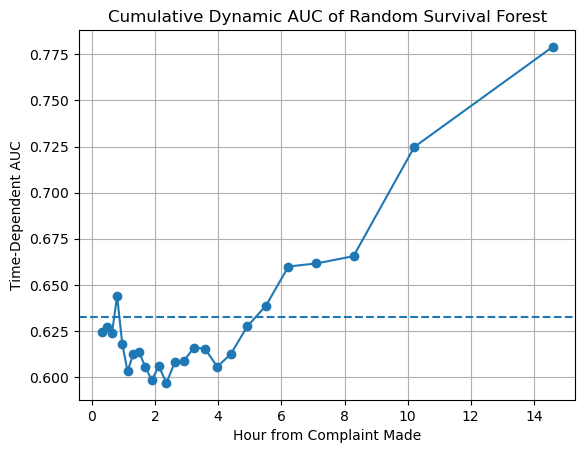

In [19]:
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train[:chunk_size],
    y_test[:chunk_size],
    rsf_risk_scores,
    times
)


plt.plot(times, rsf_auc, marker="o")
plt.axhline(rsf_mean_auc, linestyle="--")
plt.title("Cumulative Dynamic AUC of Random Survival Forest")
plt.xlabel("Hour from Complaint Made")
plt.ylabel("Time-Dependent AUC")
plt.grid(True)

In [8]:
if do_predict:
    # this may take a while
    pred_exp, pred_med = predict_surv_exp_med(rsf, X_test, chunk_size)
    gt = pd.Series([y[1] for y in y_test], name="hours_to_complete")
    final_df = pd.concat([X_test.reset_index(), gt, pred_exp.reset_index(drop=True), pred_med.reset_index(drop=True)], axis=1)
    final_df["Expected Hours to Complete"] = final_df[0]
    final_df["Median Hours to Complete"] = final_df[1]
    plot_joint(final_df, yvar="Expected Hours to Complete")
    plot_joint(final_df, yvar="Median Hours to Complete", ylab='Predicted Median Time to Close Complaint (hours)')

In [20]:
# times = np.percentile(df["hours_to_complete"], np.linspace(5, 81, 30))
heap = []
for i, col in tqdm(enumerate(X_train.columns)):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, X_test[col], times)
    # ret = concordance_index_ipcw(y_train, y_test, X_test[col], tau=times[-1], )
    in_heap = [mean_auc, col, auc,
            #    ret
               ]
    heapq.heappush(heap, in_heap)

top_10 = heapq.nlargest(10, heap)

162it [01:23,  1.94it/s]


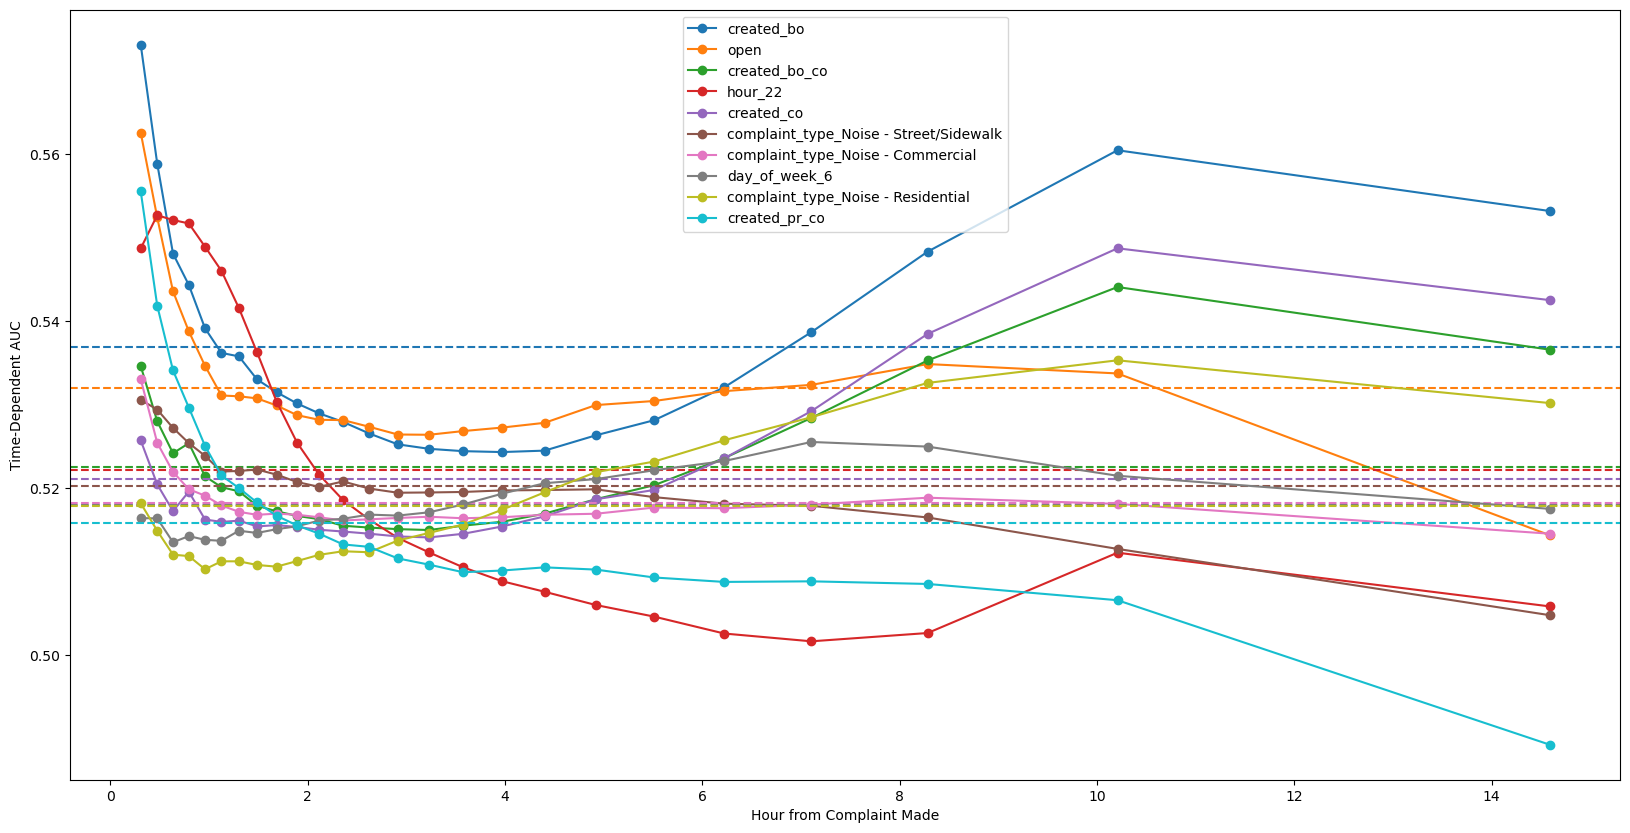

In [21]:
assets_path = pathlib.Path("../plots/rsf")
if not assets_path.exists():
    assets_path.mkdir()

fig, ax = plt.subplots()

fig.set_size_inches(20, 10)
for i, (mean_auc, col, auc) in enumerate(top_10):
    ax.plot(times, auc, marker="o", color=f"C{i}", label=col)
    ax.set_xlabel("Hour from Complaint Made")
    ax.set_ylabel("Time-Dependent AUC")
    ax.axhline(mean_auc, color=f"C{i}", linestyle="--")
    plt.legend()
fig.savefig(assets_path/f"{save_name}_TDAUC.png")

In [11]:
result = permutation_importance(rsf, X_test[:chunk_size], y_test[:chunk_size], n_repeats=5, random_state=hyper.seed, max_samples=0.10)

imp_df = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",

            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)
imp_df.loc[(imp_df['importances_mean'] != 0)]


[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.


[Parallel(n_jobs=22)]: Done  33 out of  50 | elapsed:    3.8s remaining:    2.0s
[Parallel(n_jobs=22)]: Done  50 out of  50 | elapsed:    4.5s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  33 out of  50 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=22)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  33 out of  50 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=22)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  33 out of  50 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=22)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.
[Parallel(n_jobs=22)]: Done  33 out of  50 | elapsed:    0.4s re

,importances_mean,importances_std
open_pr,0.017976,0.034203
complaint_type_Derelict Vehicle,-0.041914,0.014571
open_bo,-0.053580,0.005693
created_bo_co,-0.056628,0.017894
precinct_46.0,-0.057362,0.008331
...,...,...
precinct_108.0,-0.074964,0.000712
precinct_123.0,-0.075285,0.001465
hour_7,-0.076454,0.003310
month_8,-0.076752,0.003013


In [15]:
imp_df.loc["FELONY"]

importances_mean   -0.071251
importances_std     0.000000
Name: FELONY, dtype: float64

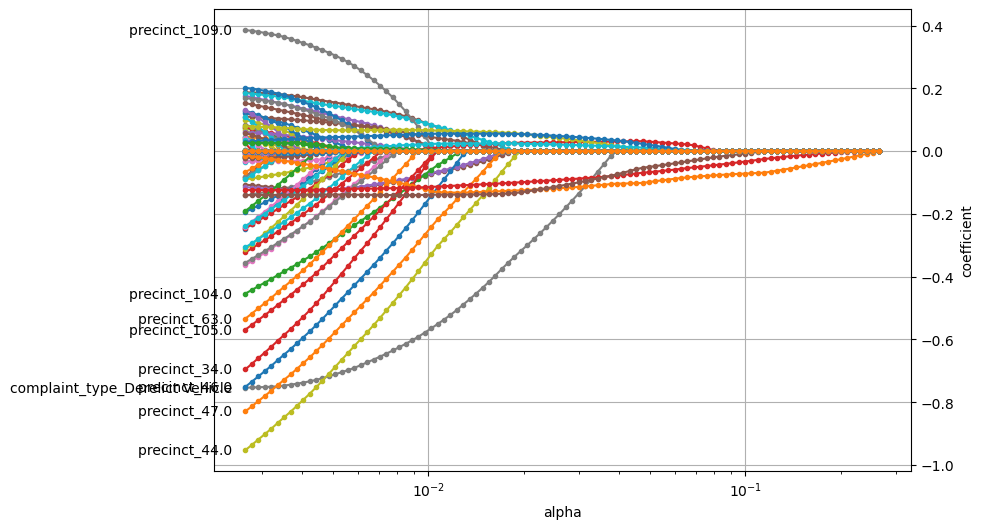

In [22]:
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_train)
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=X_train.columns, columns=np.round(cox_elastic_net.alphas_, 5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=9)

[Parallel(n_jobs=22)]: Using backend ThreadingBackend with 22 concurrent workers.


[Parallel(n_jobs=22)]: Done  33 out of  50 | elapsed:    3.7s remaining:    1.9s
[Parallel(n_jobs=22)]: Done  50 out of  50 | elapsed:    4.3s finished


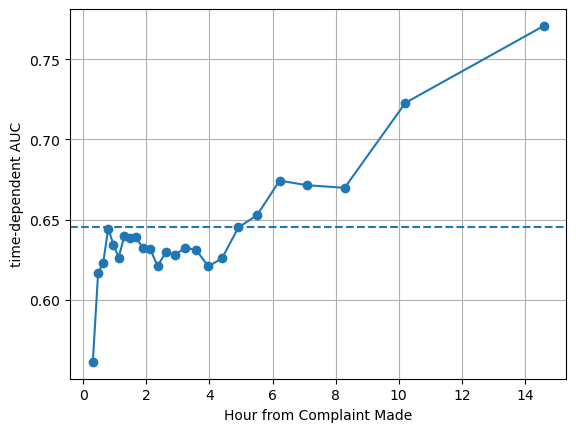

In [23]:
# times = np.arange(0, 24, 7)
cph_risk_scores = rsf.predict(X_test[:chunk_size])
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train[:chunk_size], y_test[:chunk_size], cph_risk_scores, times)

plt.plot(times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("Hour from Complaint Made")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [24]:
best_model = cox_elastic_net.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

AttributeError: 'CoxnetSurvivalAnalysis' object has no attribute 'best_estimator_'